In [1]:
# Imports necesarios - Para usar la libreria _fixedInt descargar tambien el 
# archivo .rar que se llama "tool.rar". No es necesario para esta implementacion
# pero presenta utilidades para trabajar con datos de tipo punto fijo.
# Se desarrollo una funcion auxiliar q15_to_fp para evitar usar esa libreria

# !pip install pyserial # Si se corre en Colaboratory
import serial
# from grafica.tool._fixedInt import *
import numpy as np
import matplotlib.pyplot as plt
#%matplotlib qt5

"""
    @brief: Esta funcion devuelve un número punto flotante que es la interpretación del formato q15_t
    de un número binario.
    @param: Parametro tipo string, debería ser el string compuesto por 1's y 0's: eg. '0011000000110010'
    @return: Devuelve un valor tipo float en el rango de [-1,1) que es la interpretacion del string.

    Ej: Para la entrada 0011000000110010 (entero equivalente = 12338) devuelve 0,376525

    ATENCION: Es una funcion muy rustica y no hace ningun chekeo sobre la informacion recibida ni devuelta
    mas que corroborar el tamaño del binario equivalente.
"""
def q15_to_fp(bin_equivalent = ""):  
    TOTAL_BITS = 16 # Cantidad de bits que tiene un numero q15_t

    # Se hace un chekeo de que no haya mas bits de entrada que los de un valor q15
    if(len(bin_equivalent) > TOTAL_BITS):
        return "SIZE_ERROR"

    fp_equivalent = 0 # Valor devuelto 

    # Necesito agregarle espacios al binario equivalente para poder convertirno en un arreglo np
    list_equivalent = []
    list_equivalent[:0] = bin_equivalent
    for i in range(0,TOTAL_BITS):
        list_equivalent[i] = list_equivalent[i] + " "
    # Rearmo el arreglo de strings pero con espacios alternados
    bin_equivalent = "".join([str(item) for item in list_equivalent])
    bin_equivalent.strip()  # Recorto el espacio final

    # Convierto el string a un arreglo np de floats equivalentes para poder multiplicarlos (no puedo multiplicar str)
    array_equivalent = np.fromstring(bin_equivalent, dtype='float32', sep=' ')

    # Se computa la ponderacion equivalente para cada bit de la parte fraccional (por eso empiezo en 1 y no en 0)
    for i in range(1,TOTAL_BITS):
        fp_equivalent += float(array_equivalent[i]*(2**-i))

    # Se computa el signo del numero q15 (el MSB es el signo)
    if(array_equivalent[0] == 1.0):
        fp_equivalent = fp_equivalent * -1

    if fp_equivalent >= -1.0 and fp_equivalent < 1.0:
        return fp_equivalent
    else:
        return "OUT_OF_BOUNDARY_ERROR"


# Serial transmission
---

**NOTA SI ESTÁS TRABAJANDO CON GOOGLE COLABORATORY:** Google Colab nunca se va a conectar al puerto de tu PC (recordá que se ejecuta en una PC de un datacenter).

Se abre la comunicación serial con la placa FRDMK64F.

Hay que cambiar es el puerto COMx al puerto al que este conectada la placa. 

En el firmware de la FRDMK64F se estableció velocidad 115200, sin paridad, un stop-bit y 8 bits de datos.

La información recibida se guarda en el buffer *input_buffer* para los coeficientes y en *mse_buffer* la información sobre la evolución del error.

La cantidad de datos de los coeficientes que se espera recibir es **COEFICIENTS_INPUT_SIZE**. Este valor depende de la trama (ver más abajo).

La cantidad de datos del error que se espera es **MSE_INPUT_SIZE**.

COEFICIENTS_INPUT_SIZE y MSE_INPUT_SIZE dependen de **NUMTAPS** y de **NUMFRAMES**. Estos valores deben ser seteados al mismo valor que está en el firmware de la FRDMK64F.

# Plotting
--- 

Se procesa la información recibida (se interpretan los bytes que llegan, para formar los valores de tipo q15_t, para finalmente convertirlos a su valor en punto flotante). Se plotean los valores de los coeficientes en punto flotante y en entero.

**TENER EN CUENTA QUE CADA DATO Q15_T OCUPA 16 BITS (2 BYTES) DE LARGO**

Se sabe que la trama consta de la siguiente estructura:

    Byte N°     |       Data
        0       |   lmsNormCoeff_q15[0] LowByte
        1       |   lmsNormCoeff_q15[0] HighByte
       ...      |       "
        58      |   lmsNormCoeff_q15[29] LowByte
        59      |   lmsNormCoeff_q15[29] HighByte
        60      |   FIRCoeff_q15[0] LowByte
        61      |   FIRCoeff_q15[0] HighByte
       ...      |       "
       118      |   FIRCoeff_q15[29] LowByte
       119      |   FIRCoeff_q15[29] HighByte

Métodos que pueden ser de utilidad:

El metodo int.from_bytes(...) convierte un byte a su equivalente ASCII (ej. el b'2' lo convierte a int(50) que es el codigo ASCII del char(2)):

> int.from_bytes(input_buffer[89], byteorder = "big", signed = False)
    
El metodo de str.decode("utf-8") decodifica el byte a un string (ej. el b'2' lo convierte a str(2)):
    
> input_buffer[89].decode("utf-8")

Se pueden usar las herramientas del paquete _fixedInt como son las siguientes
funciones:

> intBits = 1, fracBits = 15, signedMode = 'S', roundMode = 'round', saturateMode = 'saturate'

> q15_data = arrayFixedInt(intBits,fracBits,data,signedMode,roundMode,saturateMode)

## Error analisis
---

En el firmware solo se envían 16 bits más significativos (del bit 2 al 17). Si es mas grande que 2^17 el valor del error se satura. Esto permite que enviemos los bits menos significativos para no perder resolución. En otras palabras, no nos interesa saber si el error es muy grande, nos interesa saber que tan pequeño es al final.

A pesar que parece que el error es 0, no se aprecia por la escala pero queda oscilando en 300 a 700. 

Como se le aplica saturación al error en el firmware no se puede usar representación en punto fijo (resuelve la saturación como números negativos).


Se ha conectado al puerto: COM3


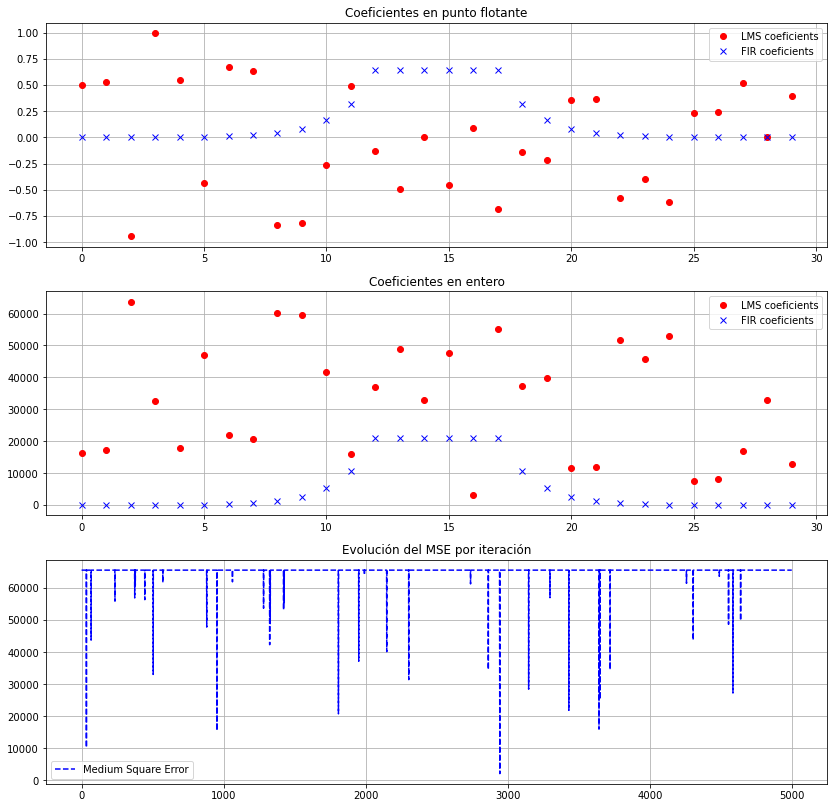

In [25]:
""" 
    Si no hay nada conectado, se inicia la interfaz de loopback y se envia una
    informacion de prueba para hacer simulacion.
"""

# if(not serial_connection.isOpen()): # Si el puerto quedó abierto de una corrida anterior hay que cerrarlo
try:
  serial_connection = serial.Serial(
                                      port='COM3',	#Configurar con el puerto asignado
                                      baudrate=115200,
                                      parity=serial.PARITY_NONE,
                                      stopbits=serial.STOPBITS_ONE,
                                      bytesize=serial.EIGHTBITS
                                    )
except:
  # Interfaz de loopback si no hay nada conectado para que no tire errores
  serial_connection = serial.serial_for_url('loop://', timeout=1)

print("Se ha conectado al puerto: " + serial_connection.port)

# CAMBIAR POR EL MISMO NUMERO QUE ESTE EN EL CODIGO DE .C
NUMTAPS = 30
NUMFRAME = 5000
COEFICIENTS_INPUT_SIZE = NUMTAPS*4    # Cantidad de datos que representan a los coeficientes
MSE_INPUT_SIZE  = NUMFRAME*2          # Cantidad de datos que representan a la evolucion del MSE

input_buffer = []   # Lista donde se almacenaran los datos de los coeficientes recibidos
mse_buffer = []     # Lista donde se almacenaran los datos del MSE

serial_connection.flushInput()  # Vacia los buffer de entrada del puerto serie
serial_connection.flushOutput() # y salida

# Si se tiene abierta la interfaz de loopback se envia informacion de prueba 
# para hacer una simulacion
if serial_connection.port == 'loop://':
  output_buffer = []
  for i in range(0, COEFICIENTS_INPUT_SIZE): # Se llena el buffer con bytes (eg. b'\x00', b'\x01', b'\x02', b'\x03'...)
    output_buffer.append(int(i))
  serial_connection.write(output_buffer)

if serial_connection.isOpen():     # Verifica si el puerto serie esta abierto
    while len(input_buffer) < COEFICIENTS_INPUT_SIZE:  # Almacena toda la informacion recibida
        while(serial_connection.inWaiting()>0):
            read_data = serial_connection.read(1)
            input_buffer.append(read_data)
    while len(mse_buffer) < MSE_INPUT_SIZE:  # Almacena toda la informacion recibida
        while(serial_connection.inWaiting()>0):
            read_data = serial_connection.read(1)
            mse_buffer.append(read_data)

# Para debugg...
# print("bytes recibidos {}".format(len(input_buffer )))
# print(input_buffer)
# print("Tipo de dato recibido: " + str(type(input_buffer[0])))

serial_connection.close() # Recordar cerrar siempre la conexion!!

""""
    Se procesa la informacion en el input_buffer
"""

coeficients_buffer_fp = []
coeficients_buffer_int = []

for i in range(0,len(input_buffer),2):
  # Construyo los binarios equivalentes, le saco los primeros 2 caracteres que son "0b".
  # Se rellena con 0's los MSB para tener un dato de 8 bits de longitud.
  # El tipo de dato que son low_byte y high_byte son str.
  low_byte = bin(int.from_bytes(input_buffer[i],byteorder='big'))[2:].zfill(8)
  high_byte = bin(int.from_bytes(input_buffer[i+1],byteorder='big'))[2:].zfill(8)
  q15_value = high_byte + low_byte
  int_value = (int(low_byte,2) | int(high_byte,2)<<8) # Obtengo los enteros equivalentes
  coeficients_buffer_int.append(int_value)
  # Transformo los valores de string a punto flotante equivalente de su valor en q15 y lo guardo en un arreglo
  coeficients_buffer_fp.append(q15_to_fp(q15_value))

""""
    Se procesa la informacion en el mse_buffer
"""
mse_fp = []
mse_int = []
for i in range(0,len(mse_buffer),2):
  low_byte = bin(int.from_bytes(mse_buffer[i],byteorder='big'))[2:].zfill(8)
  high_byte = bin(int.from_bytes(mse_buffer[i+1],byteorder='big'))[2:].zfill(8)
  int_value = (int(low_byte,2) | int(high_byte,2)<<8) # Obtengo los enteros equivalentes
  mse_int.append(int_value)
  # Transformo los valores de string a punto flotante equivalente de su valor en q15 y lo guardo en un arreglo
  # q15_value = high_byte + low_byte
  # mse_fp.append(q15_to_fp(q15_value))

"""
    Se grafican los coeficientes de ambos filtros.
"""
fig = plt.figure(figsize=[14,14])
# Se crea una lista para el eje X. Serian los indices de los coeficientes
x_axis = list(range(int(len(coeficients_buffer_fp)/2)))

# Grafico en pto flotante
ax = fig.add_subplot(3,1,1)
ax.plot(x_axis, coeficients_buffer_fp[:int(len(coeficients_buffer_fp)/2)], 'ro') # Coeficientes del filtro LMS
ax.plot(x_axis, coeficients_buffer_fp[int(len(coeficients_buffer_fp)/2):], 'bx') # Coeficientes del filtro FIR (planta)
ax.legend(["LMS coeficients", "FIR coeficients"])
ax.grid(True)
ax.set_title("Coeficientes en punto flotante")

# Grafico en valores enteros
ax = fig.add_subplot(3,1,2)
ax.plot(x_axis, coeficients_buffer_int[:int(len(coeficients_buffer_int)/2)], 'ro') # Coeficientes del filtro LMS
ax.plot(x_axis, coeficients_buffer_int[int(len(coeficients_buffer_int)/2):], 'bx') # Coeficientes del filtro FIR (planta)
ax.legend(["LMS coeficients", "FIR coeficients"])
ax.set_title("Coeficientes en entero")
ax.grid(True)

"""
    Se grafica la evolucion del MSE.
"""
ax = fig.add_subplot(3,1,3)
x_axis = list(range(int(len(mse_int))))
# x_axis = list(range(int(len(mse_fp))))
ax.plot(x_axis, mse_int, 'b--')
# ax.plot(x_axis, mse_fp, 'b--')
ax.legend(["Medium Square Error"])
ax.set_title("Evolución del MSE por iteración")
ax.grid(True)
